In [225]:
import sys
from pathlib import Path
import pandas as pd 
import numpy as np
import keras
from keras.layers import LSTM, Dense, Dropout, LeakyReLU, GRU, BatchNormalization,  Flatten, MaxPooling2D, TimeDistributed, ConvLSTM1D, Input
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
sys.path.append(str(Path("../../..").resolve()))
from src.constants import model_data_dir


In [226]:
remove_cols = ["sc_1d_fwd_rel_d", "mom_1d_fwd_rel_d"]

df_train = pd.read_csv(model_data_dir / "train_classification.csv").drop(remove_cols + ["Date"], axis=1)
df_test = pd.read_csv(model_data_dir / "test_classification.csv").drop(remove_cols, axis=1)
test_dates = pd.to_datetime(df_test["Date"])
df_test.drop("Date", axis=1, inplace=True)

In [227]:
((y_train, x_train), (y_test, x_test)) = ((df_train.pop("value_1d_fwd_rel_d"), df_train), (df_test.pop("value_1d_fwd_rel_d"), df_test))

In [228]:
win_length = 60
batch_size = 180
num_features = x_train.shape[1]
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)


## Conv LSTM

In [229]:
model = Sequential()
model.add(Input(shape = ( win_length, num_features, 1)))
model.add(ConvLSTM1D(filters=64, kernel_size=2, padding='same', return_sequences=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2)) 
model.add(ConvLSTM1D(filters=64, kernel_size=2, padding='same', return_sequences=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2)) 
model.add(ConvLSTM1D(filters=64, kernel_size=2, padding='same', return_sequences=False))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2)) 
model.add(Flatten())
model.add(Dense(10))
model.add(Dense(1, activation="sigmoid"))

In [230]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                            patience = 20)

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stop])

Epoch 1/50
19/19 [==============================] - 164s 8s/step - loss: 0.6914 - accuracy: 0.5399 - val_loss: 0.6965 - val_accuracy: 0.4858
Epoch 2/50
19/19 [==============================] - 152s 8s/step - loss: 0.6844 - accuracy: 0.5566 - val_loss: 0.6991 - val_accuracy: 0.4901
Epoch 3/50
19/19 [==============================] - 150s 8s/step - loss: 0.6802 - accuracy: 0.5688 - val_loss: 0.6996 - val_accuracy: 0.4918
Epoch 4/50
19/19 [==============================] - 151s 8s/step - loss: 0.6775 - accuracy: 0.5759 - val_loss: 0.7033 - val_accuracy: 0.4874
Epoch 5/50
19/19 [==============================] - 1034s 57s/step - loss: 0.6710 - accuracy: 0.5870 - val_loss: 0.7134 - val_accuracy: 0.4995
Epoch 6/50
16/19 [========================>.....] - ETA: 1:28 - loss: 0.6702 - accuracy: 0.5889

KeyboardInterrupt: 

## LSTM

In [231]:
model = Sequential()
model.add(Input(shape=(win_length, num_features)))
model.add(LSTM(256, return_sequences=True, bias_initializer="zeros", unit_forget_bias=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(LSTM(128, return_sequences=True, bias_initializer="zeros", unit_forget_bias=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2)) 
model.add(LSTM(64, return_sequences=True, bias_initializer="zeros", unit_forget_bias=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2)) 
model.add(LSTM(32, return_sequences=False, bias_initializer="zeros", unit_forget_bias=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(1, activation="sigmoid"))

In [232]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                            patience = 20)

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stop])

Epoch 1/50
19/19 [==============================] - 22s 721ms/step - loss: 0.6910 - accuracy: 0.5396 - val_loss: 0.6954 - val_accuracy: 0.4863
Epoch 2/50
19/19 [==============================] - 11s 604ms/step - loss: 0.6825 - accuracy: 0.5596 - val_loss: 0.7001 - val_accuracy: 0.4967
Epoch 3/50
19/19 [==============================] - 12s 619ms/step - loss: 0.6735 - accuracy: 0.5896 - val_loss: 0.7106 - val_accuracy: 0.4973
Epoch 4/50
19/19 [==============================] - 12s 632ms/step - loss: 0.6614 - accuracy: 0.6030 - val_loss: 0.7269 - val_accuracy: 0.4923
Epoch 5/50
19/19 [==============================] - 12s 648ms/step - loss: 0.6618 - accuracy: 0.6048 - val_loss: 0.7209 - val_accuracy: 0.5000
Epoch 6/50
19/19 [==============================] - 12s 659ms/step - loss: 0.6504 - accuracy: 0.6275 - val_loss: 0.7426 - val_accuracy: 0.4890
Epoch 7/50
19/19 [==============================] - 13s 703ms/step - loss: 0.6521 - accuracy: 0.6200 - val_loss: 0.7268 - val_accuracy: 0.4874

In [233]:
predictions = model.predict_generator(test_generator)
df_preds = pd.DataFrame({"ds": test_dates[win_length:], "y": y_test[win_length:], })
df_preds["yhat"] = predictions.flatten()

/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_73342/953353012.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


<AxesSubplot:>

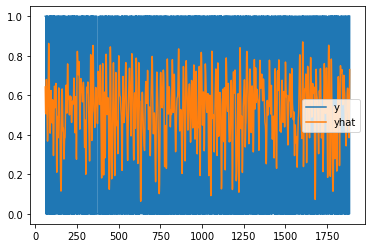

In [234]:
df_preds[["y", "yhat"]].plot()

## GRU 

In [235]:
model_gru = Sequential()
model_gru.add(GRU(256, input_shape= (win_length, num_features), return_sequences=True))
model_gru.add(LeakyReLU(alpha=0.5)) 
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.3)) 
model_gru.add(GRU(128, input_shape= (win_length, num_features), return_sequences=True))
model_gru.add(LeakyReLU(alpha=0.5)) 
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.3)) 
model_gru.add(LSTM(32, input_shape= (win_length, num_features), return_sequences=False))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.3)) 
model_gru.add(Dense(1, activation="sigmoid"))

In [236]:
early_stop_gru = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                               patience = 20)

model_gru.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history_gru = model_gru.fit(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False, callbacks=[early_stop_gru])

Epoch 1/50
19/19 [==============================] - 17s 534ms/step - loss: 0.8666 - accuracy: 0.4979 - val_loss: 0.6970 - val_accuracy: 0.4918
Epoch 2/50
19/19 [==============================] - 10s 514ms/step - loss: 0.7489 - accuracy: 0.5500 - val_loss: 0.6999 - val_accuracy: 0.4869
Epoch 3/50
19/19 [==============================] - 10s 513ms/step - loss: 0.7003 - accuracy: 0.6010 - val_loss: 0.7018 - val_accuracy: 0.4819
Epoch 4/50
19/19 [==============================] - 10s 523ms/step - loss: 0.6563 - accuracy: 0.6179 - val_loss: 0.7025 - val_accuracy: 0.4803
Epoch 5/50
19/19 [==============================] - 9s 487ms/step - loss: 0.6524 - accuracy: 0.6263 - val_loss: 0.7040 - val_accuracy: 0.4830
Epoch 6/50
19/19 [==============================] - 10s 505ms/step - loss: 0.6380 - accuracy: 0.6459 - val_loss: 0.7043 - val_accuracy: 0.4743
Epoch 7/50
19/19 [==============================] - 9s 494ms/step - loss: 0.6308 - accuracy: 0.6540 - val_loss: 0.7088 - val_accuracy: 0.4682
E

In [237]:
predictions_gru = model_gru.predict_generator(test_generator)
df_preds_gru = pd.DataFrame({"ds": test_dates[win_length:], "y": y_test[win_length:], })
df_preds_gru["yhat"] = predictions_gru.flatten()

/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_73342/2811852203.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_gru = model_gru.predict_generator(test_generator)


<AxesSubplot:>

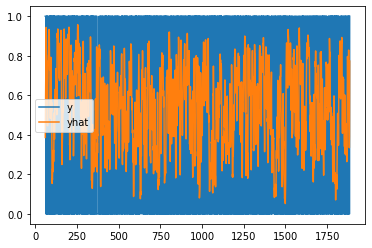

In [238]:
df_preds_gru[["y", "yhat"]].plot()

In [ ]:
predictions_gru = model_gru.predict_generator(test_generator)

/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_73342/303773502.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_gru = model_gru.predict_generator(test_generator)


In [ ]:
preds = predictions_gru.flatten()
(np.where(preds > 0.5, 1, 0) == y_test[win_length:]).mean()

0.48504273504273504

In [ ]:
remove_cols = ["sc_1d_fwd_rel_d", "mom_1d_fwd_rel_d"]

df_train = pd.read_csv(model_data_dir / "train_classification.csv").drop(remove_cols + ["Date"], axis=1)
df_test = pd.read_csv(model_data_dir / "test_classification.csv").drop(remove_cols, axis=1)
test_dates = pd.to_datetime(df_test["Date"])
df_test.drop("Date", axis=1, inplace=True)